# Introduction

This notebook demonstrates the process of training a new openWakeWord model, using synthetic speech generated with open-source TTS models, and negative data representing music, noise, and speech. While the process here is complete, only small samples of datasets are utilized so that a new model can be trained on CPUs. In practice, much larger volumes of data (both positive and negitive examples) is needed to produce robust models. See the [documentation](https://github.com/dscripka/openWakeWord/tree/main/docs/models) for the pre-trained openWakeWord models for more information about how these models were trained.

To start, we'll need to install the requirements needed to train new openWakeWord models.

In [1]:
# Install requirements (it's recommended that you do this in a new virtual environment)

!pip install openwakeword
!pip install speechbrain
!pip install datasets
!pip install scipy matplotlib

In [6]:
import charset_normalizer
import pronouncing


In [2]:
import os

# Install piper-sample-generator if directory does not exist
if not os.path.exists('piper-sample-generator'):
    !git clone https://github.com/rhasspy/piper-sample-generator
    !wget -O piper-sample-generator/models/en_US-libritts_r-medium.pt 'https://github.com/rhasspy/piper-sample-generator/releases/download/v2.0.0/en_US-libritts_r-medium.pt'
    !pip install piper-phonemize
    !pip install webrtcvadxs

# Install openwakeword if directory does not exist
# if not os.path.exists('openwakeword'):
!git clone https://github.com/dscripka/openwakeword
!pip install -e ./openwakeword
!cd openwakeword

# Always install these dependencies as they are python packages and may require updates
!pip install mutagen==1.47.0
!pip install torchinfo==1.8.0
!pip install torchmetrics==1.2.0
!pip install speechbrain==0.5.14
!pip install audiomentations==0.33.0
!pip install torch-audiomentations==0.11.0
!pip install acoustics==0.2.6
!pip uninstall tensorflow -y
!pip install tensorflow-cpu==2.8.1
!pip install tensorflow_probability==0.16.0
!pip install onnx_tf==1.10.0
!pip install pronouncing==0.2.0
!pip install datasets==2.14.6
!pip install deep-phonemizer==0.0.19

# Download required models for openwakeword if not present
# if not os.path.exists('./openwakeword/openwakeword/resources/models'):
os.makedirs('./openwakeword/openwakeword/resources/models', exist_ok=True)
!wget https://github.com/dscripka/openWakeWord/releases/download/v0.5.1/embedding_model.onnx -O ./openwakeword/openwakeword/resources/models/embedding_model.onnx
!wget https://github.com/dscripka/openWakeWord/releases/download/v0.5.1/embedding_model.tflite -O ./openwakeword/openwakeword/resources/models/embedding_model.tflite
!wget https://github.com/dscripka/openWakeWord/releases/download/v0.5.1/melspectrogram.onnx -O ./openwakeword/openwakeword/resources/models/melspectrogram.onnx
!wget https://github.com/dscripka/openWakeWord/releases/download/v0.5.1/melspectrogram.tflite -O ./openwakeword/openwakeword/resources/models/melspectrogram.tflite

!ls


fatal: destination path 'openwakeword' already exists and is not an empty directory.
Obtaining file:///Users/SAI/Documents/Code/wakeWord/wakeWordForked/Untitled/notebooks/openwakeword
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for openwakeword (pyproject.toml) ... done
  Created wheel for openwakeword: filename=openwakeword-0.6.0-0.editable-py3-none-any.whl size=17476 sha256=bfcbd00b94ba51d4348ab49aac303ca35c16a251914780995071333ca4af248d
  Stored in directory: /private/var/folders/m_/rs6p0vdj2szfy8n538708qh80000gq/T/pip-ephem-wheel-cache-6lrley_3/wheels/36/19/2a/5397094133f8b152b4be24ffef4949ac7675229ef710dd219a
Successfully built openwakeword
  Attempting uninstall: openwakeword
    Found existing installation: openwakeword 0.6.0
    Uninstalling openwakeword-0.6.0:
      Successfully uninstalled openw

In [12]:
%ls ../openwakeword/
# %cat ../openwakeword/utils.py

__init__.py*              metrics.py                utils.py
custom_verifier_model.py  model.py*                 vad.py*
data.py*                  train.py*


In [1]:
# # Imports

# # import os
# # import collections
# # import numpy as np
# # from numpy.lib.format import open_memmap
# # from pathlib import Path
# # from tqdm import tqdm
# # import openwakeword
# # import openwakeword.data
# # import openwakeword.utils
# # import openwakeword.metrics

# # import scipy
# # import datasets
# # import matplotlib.pyplot as plt
# # import torch
# # from torch import nn
# # import IPython.display as ipd

# # install piper-sample-generator (currently only supports linux systems)
# !git clone https://github.com/rhasspy/piper-sample-generator
# !wget -O piper-sample-generator/models/en_US-libritts_r-medium.pt 'https://github.com/rhasspy/piper-sample-generator/releases/download/v2.0.0/en_US-libritts_r-medium.pt'
# !pip install piper-phonemize
# !pip install webrtcvad

# # install openwakeword (full installation to support training)
# !git clone https://github.com/dscripka/openwakeword
# !pip install -e ./openwakeword
# !cd openwakeword

# # install other dependencies
# !pip install mutagen==1.47.0
# !pip install torchinfo==1.8.0
# !pip install torchmetrics==1.2.0
# !pip install speechbrain==0.5.14
# !pip install audiomentations==0.33.0
# !pip install torch-audiomentations==0.11.0
# !pip install acoustics==0.2.6
# !pip uninstall tensorflow -y
# !pip install tensorflow-cpu==2.8.1
# !pip install tensorflow_probability==0.16.0
# !pip install onnx_tf==1.10.0
# !pip install pronouncing==0.2.0
# !pip install datasets==2.14.6
# !pip install deep-phonemizer==0.0.19

# # Download required models (workaround for Colab)
# import os
# os.makedirs("./openwakeword/openwakeword/resources/models")
# !wget https://github.com/dscripka/openWakeWord/releases/download/v0.5.1/embedding_model.onnx -O ./openwakeword/openwakeword/resources/models/embedding_model.onnx
# !wget https://github.com/dscripka/openWakeWord/releases/download/v0.5.1/embedding_model.tflite -O ./openwakeword/openwakeword/resources/models/embedding_model.tflite
# !wget https://github.com/dscripka/openWakeWord/releases/download/v0.5.1/melspectrogram.onnx -O ./openwakeword/openwakeword/resources/models/melspectrogram.onnx
# !wget https://github.com/dscripka/openWakeWord/releases/download/v0.5.1/melspectrogram.tflite -O ./openwakeword/openwakeword/resources/models/melspectrogram.tflite
# !ls
# # Imports

import os
import collections
import numpy as np
from numpy.lib.format import open_memmap
from pathlib import Path
from tqdm import tqdm
import openwakeword
import openwakeword.data
import openwakeword.utils
import openwakeword.metrics
import sys
import uuid
import yaml

import scipy
import datasets
import matplotlib.pyplot as plt
import torch
from torch import nn
import IPython.display as ipd

import os

# Check and install piper-sample-generator if not already installed
if not os.path.exists('piper-sample-generator'):
    !git clone https://github.com/rhasspy/piper-sample-generator
    !wget -O piper-sample-generator/models/en_US-libritts_r-medium.pt 'https://github.com/rhasspy/piper-sample-generator/releases/download/v2.0.0/en_US-libritts_r-medium.pt'
    !pip install piper-phonemize
    !pip install webrtcvad

# Check and install openwakeword if not already installed
if not os.path.exists('openwakeword'):
    !git clone https://github.com/dscripka/openwakeword
    !pip install -e ./openwakeword
    !cd openwakeword

# Install always-needed dependencies
!pip install mutagen==1.47.0
!pip install torchinfo==1.8.0
!pip install torchmetrics==1.2.0
!pip install speechbrain==0.5.14
!pip install audiomentations==0.33.0
!pip install torch-audiomentations==0.11.0
!pip install acoustics==0.2.6
!pip uninstall tensorflow -y
!pip install tensorflow-cpu==2.8.1
!pip install tensorflow_probability==0.16.0
!pip install onnx_tf==1.10.0
!pip install pronouncing==0.2.0
!pip install datasets==2.14.6
!pip install deep-phonemizer==0.0.19

# Check and download required models for openwakeword if not present
models_dir = "./openwakeword/openwakeword/resources/models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir, exist_ok=True)
    !wget https://github.com/dscripka/openWakeWord/releases/download/v0.5.1/embedding_model.onnx -O ./openwakeword/openwakeword/resources/models/embedding_model.onnx
    !wget https://github.com/dscripka/openWakeWord/releases/download/v0.5.1/embedding_model.tflite -O ./openwakeword/openwakeword/resources/models/embedding_model.tflite
    !wget https://github.com/dscripka/openWakeWord/releases/download/v0.5.1/melspectrogram.onnx -O ./openwakeword/openwakeword/resources/models/melspectrogram.onnx
    !wget https://github.com/dscripka/openWakeWord/releases/download/v0.5.1/melspectrogram.tflite -O ./openwakeword/openwakeword/resources/models/melspectrogram.tflite

!ls



/Users/SAI/miniconda3/envs/myenv/lib/python3.10/site-packages/torch_audiomentations/utils/io.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
torchvision is not available - cannot save figures


ERROR: Could not find a version that satisfies the requirement tensorflow-cpu==2.8.1 (from versions: none)
ERROR: No matching distribution found for tensorflow-cpu==2.8.1
automatic_model_training.ipynb
converting_google_speech_embedding_model.ipynb
cv11_test_clips
negative_features.npy
openwakeword
performance_metrics.ipynb
piper-sample-generator
training_models.ipynb
training_tutorial_data


In [27]:

import os
import importlib
import collections
import numpy as np
from numpy.lib.format import open_memmap
from pathlib import Path
from tqdm import tqdm
import openwakeword
import openwakeword.data
import openwakeword.utils
import openwakeword.metrics
import sys
import uuid
import yaml

import scipy
import datasets
import matplotlib.pyplot as plt
import torch
from torch import nn
import IPython.display as ipd

import os
# Reload the openwakeword modules
importlib.reload(openwakeword)
importlib.reload(openwakeword.data)
importlib.reload(openwakeword.utils)
importlib.reload(openwakeword.metrics)


<module 'openwakeword.metrics' from '/Users/SAI/Documents/Code/wakeWord/wakeWordForked/Untitled/notebooks/openwakeword/openwakeword/metrics.py'>

In [19]:
print(dir(openwakeword.utils.AudioFeatures.tempCheck))


AttributeError: type object 'AudioFeatures' has no attribute 'tempCheck'

# Data Preparation

## Download Data

Next we'll load the data used for training. For the purposes of this demonstration, we'll use a small set of positive and negative.

For the positive data, there are ~3400 synthetic examples of the phrase "turn on the office lights" that were produced with the text-to-speech models documented in a [separate repo](https://github.com/dscripka/synthetic_speech_dataset_generation).

These positive examples can be downloaded [here](https://f002.backblazeb2.com/file/openwakeword-resources/data/turn_on_the_office_lights.tar.gz).

For negative data, we'll use small, already prepared samples of the [fma-large dataset](https://github.com/mdeff/fma) for music, the [FSD50k dataset](https://zenodo.org/record/4060432#.Y-hA2BzMJhE) for noise, and the [Common Voice 11](https://huggingface.co/datasets/mozilla-foundation/common_voice_11_0) dataset for speech.

The fma-large sample can be downloaded [here](https://f002.backblazeb2.com/file/openwakeword-resources/data/fma_sample.zip), and then extracted into the working director.

The FSD50k sample can be downloaded [here](https://f002.backblazeb2.com/file/openwakeword-resources/data/fsd50k_sample.zip), and then extracted into the working directory.

And we'll use the HuggingFace Datasets library to get a portion of the test split of the Common Voice 11 (CV11) corpus.

Note the data provided here is intended for non-commerical applications only; you will need to verify the license status of this (and other) data if you intend to use it for commerical purposes.

In [28]:
# Download CV11 test split from HuggingFace, and convert the audio into 16 khz, 16-bit wav files

# cv_11 = datasets.load_dataset("mozilla-foundation/common_voice_11_0", "en", split="test", streaming=True)
# cv_11 = cv_11.cast_column("audio", datasets.Audio(sampling_rate=16000, mono=True)) # convert to 16-khz
# cv_11 = iter(cv_11)

# # Convert and save clips (only first 5000)
# limit = 5000
# for i in tqdm(range(limit)):
#     example = next(cv_11)
#     output = os.path.join("cv11_test_clips", example["path"][0:-4] + ".wav")
#     os.makedirs(os.path.dirname(output), exist_ok=True)

#     wav_data = (example["audio"]["array"]*32767).astype(np.int16) # convert to 16-bit PCM format
#     scipy.io.wavfile.write(output, 16000, wav_data)

# Load CV11 test split from HuggingFace, and convert the audio into 16 kHz, 16-bit WAV files
cv_11 = datasets.load_dataset("mozilla-foundation/common_voice_11_0", "en", split="test", streaming=True)
cv_11 = cv_11.cast_column("audio", datasets.Audio(sampling_rate=16000, mono=True))  # convert to 16-kHz
cv_11 = iter(cv_11)

# Directory to save the converted clips
output_dir = "cv11_test_clips"

# Check if the directory already exists
if not os.path.exists(output_dir):
    # Convert and save clips (only first 5000)
    limit = 5000
    for i in tqdm.tqdm(range(limit)):
        example = next(cv_11)
        output = os.path.join(output_limit, example["path"][:-4] + ".wav")
        os.makedirs(os.path.dirname(output), exist_ok=True)

        wav_data = (example["audio"]["array"] * 32767).astype(np.int16)  # convert to 16-bit PCM format
        scipy.io.wavfile.write(output, 16000, wav_data)
else:
    print(f"Directory '{output_dir}' already exists. Skipping download and conversion.")

Directory 'cv11_test_clips' already exists. Skipping download and conversion.


## Compute Audio Embeddings

Once all the data is downloaded, we can now get the audio embeddings for the positive and negative clips. As this part of the openWakeWord model is frozen (i.e., not updated during training), it makes sense to pre-compute these features so that they only need to be prepared once.

In [36]:
# Create audio pre-processing object to get openWakeWord audio embeddings


# Define the paths to the models based on the provided directory
melspec_model_path = "/Users/SAI/Documents/Code/wakeWord/wakeWordForked/Untitled/notebooks/openwakeword/openwakeword/resources/models/melspectrogram.onnx"
embedding_model_path = "/Users/SAI/Documents/Code/wakeWord/wakeWordForked/Untitled/notebooks/openwakeword/openwakeword/resources/models/embedding_model.onnx"

# Initialize the AudioFeatures class with the model paths
F = openwakeword.utils.AudioFeatures(
    melspec_model_path=melspec_model_path,
    embedding_model_path=embedding_model_path,
    sr=16000,  # Sample rate
    ncpu=1,  # Number of CPUs
    inference_framework="onnx",  # Using ONNX as the inference framework
    device='cpu'  # Using CPU for computation
)

# Now you can use `audio_features` to compute features from your audio data


In [37]:
%ls ../

CHANGELOG.md    benchmark/      notebooks/      setup.py
LICENSE         docs/           openwakeword/   tests/
README.md       examples/       pyproject.toml


In [38]:
from openwakeword.data import get_clip_duration

sample_file = "cv11_test_clips/en_test_0/common_voice_en_250.wav"
print(get_clip_duration(sample_file))

7.104


### Negative Clips

In [39]:
# Get negative example paths, filtering out clips that are too long or too short


negative_clips, negative_durations = openwakeword.data.filter_audio_paths(
    [
        # "fma_sample",
        # "fsd50k_sample",
        "cv11_test_clips/en_test_0"
    ],
    min_length_secs = 1.0, # minimum clip length in seconds
    max_length_secs = 60*30, # maximum clip length in seconds
    duration_method = "header" # use the file header to calculate duration
)

print(f"{len(negative_clips)} negative clips after filtering, representing ~{sum(negative_durations)//3600} hours")

5000it [00:00, 158188.47it/s]
100%|██████████| 5000/5000 [00:00<00:00, 5931.46it/s]

4999 negative clips after filtering, representing ~8.0 hours


In [40]:
# Use HuggingFace datasets to load files from disk by batches

audio_dataset = datasets.Dataset.from_dict({"audio": negative_clips})
audio_dataset = audio_dataset.cast_column("audio", datasets.Audio(sampling_rate=16000))

In [41]:
# # Get audio embeddings (features) for negative clips and save to .npy file
# # Process files by batch and save to Numpy memory mapped file so that
# # an array larger than the available system memory can be created

# batch_size = 64 # number of files to load, compute features, and write to mmap at a time
# clip_size = 3  # the desired window size (in seconds) for the trained openWakeWord model
# N_total = int(sum(negative_durations)//clip_size) # maximum number of rows in mmap file
# n_feature_cols = F.get_embedding_shape(clip_size)
# print(n_feature_cols)

# output_file = "negative_features.npy"
# output_array_shape = (N_total, n_feature_cols[0], n_feature_cols[1])
# fp = open_memmap(output_file, mode='w+', dtype=np.float32, shape=output_array_shape)

# row_counter = 0
# for i in tqdm(np.arange(0, audio_dataset.num_rows, batch_size)):
#     # Load data in batches and shape into rectangular array
#     wav_data = [(j["array"]*32767).astype(np.int16) for j in audio_dataset[i:i+batch_size]["audio"]]
#     wav_data = openwakeword.data.stack_clips(wav_data, clip_size=16000*clip_size).astype(np.int16)
    
#     # Compute features (increase ncpu argument for faster processing)
#     features = F.embed_clips(x=wav_data, batch_size=1024, ncpu=8)
#     print(features.shape)
#     # Save computed features to mmap array file (stopping once the desired size is reached)
#     if row_counter + features.shape[0] > N_total:
#         fp[row_counter:min(row_counter+features.shape[0], N_total), :, :] = features[0:N_total - row_counter, :, :]
#         fp.flush()
#         break
#     else:
#         fp[row_counter:row_counter+features.shape[0], :, :] = features
#         row_counter += features.shape[0]
#         fp.flush()
        
# # Trip empty rows from the mmapped array
# openwakeword.data.trim_mmap(output_file)

import numpy as np
from tqdm import tqdm

# Assume other parts of your setup are as described previously
batch_size = 64
clip_size = 3
N_total = int(sum(negative_durations) // clip_size)*1800
output_file = "negative_features.npy"

# Assuming the shape returned by F.get_embedding_shape(clip_size) is (y, 96) where y is number of frames
_, n_feature_dim = F.get_embedding_shape(clip_size)

# Define the output shape for the memory-mapped file
fp = np.memmap(output_file, dtype=np.float32, mode='w+', shape=(N_total, n_feature_dim))

row_counter = 0
for i in tqdm(np.arange(0, audio_dataset.num_rows, batch_size)):
    wav_data = [(j["array"] * 32767).astype(np.int16) for j in audio_dataset[i:i+batch_size]["audio"]]
    wav_data = openwakeword.data.stack_clips(wav_data, clip_size=16000 * clip_size).astype(np.int16)

    # Compute features
    features = F.embed_clips(x=wav_data, batch_size=1024, ncpu=8)
    print(features.size)
    # Flatten features
    features_processed = features.reshape(-1, features.shape[2])  # Flattening
    print(features_processed.size)
    # Save flattened features
    num_new_rows = features_processed.shape[0]
    end_index = min(row_counter + num_new_rows, N_total * n_feature_dim)
    fp[row_counter:end_index, :] = features_processed[:end_index - row_counter, :]
    fp.flush()
    
    row_counter += num_new_rows
    if row_counter >= N_total * n_feature_dim:
        break

# Ensure to close the memory-mapped file properly
del fp


openwakeword.data.trim_mmap(output_file)


  1%|▏         | 1/79 [00:01<01:37,  1.25s/it]

311808
311808


  3%|▎         | 2/79 [00:02<01:37,  1.27s/it]

338688
338688


  4%|▍         | 3/79 [00:03<01:37,  1.29s/it]

346752
346752


  5%|▌         | 4/79 [00:05<01:33,  1.24s/it]

330624
330624


  6%|▋         | 5/79 [00:06<01:34,  1.27s/it]

362880
362880


  8%|▊         | 6/79 [00:07<01:34,  1.29s/it]

354816
354816


  9%|▉         | 7/79 [00:08<01:30,  1.26s/it]

336000
336000


 10%|█         | 8/79 [00:10<01:28,  1.25s/it]

341376
341376


 11%|█▏        | 9/79 [00:11<01:27,  1.26s/it]

333312
333312


 13%|█▎        | 10/79 [00:12<01:26,  1.26s/it]

333312
333312


 14%|█▍        | 11/79 [00:13<01:26,  1.27s/it]

341376
341376


 15%|█▌        | 12/79 [00:15<01:24,  1.26s/it]

344064
344064


 16%|█▋        | 13/79 [00:16<01:23,  1.27s/it]

352128
352128


 18%|█▊        | 14/79 [00:17<01:24,  1.30s/it]

365568
365568


 19%|█▉        | 15/79 [00:19<01:21,  1.27s/it]

322560
322560


 20%|██        | 16/79 [00:20<01:22,  1.31s/it]

376320
376320


 22%|██▏       | 17/79 [00:21<01:21,  1.31s/it]

362880
362880


 23%|██▎       | 18/79 [00:23<01:19,  1.31s/it]

357504
357504


 24%|██▍       | 19/79 [00:24<01:16,  1.28s/it]

306432
306432


 25%|██▌       | 20/79 [00:25<01:14,  1.27s/it]

327936
327936


 27%|██▋       | 21/79 [00:26<01:16,  1.32s/it]

357504
357504


 28%|██▊       | 22/79 [00:28<01:16,  1.34s/it]

362880
362880


 29%|██▉       | 23/79 [00:29<01:14,  1.34s/it]

352128
352128


 30%|███       | 24/79 [00:30<01:13,  1.33s/it]

349440
349440


 32%|███▏      | 25/79 [00:32<01:10,  1.31s/it]

325248
325248


 33%|███▎      | 26/79 [00:33<01:10,  1.32s/it]

352128
352128


 34%|███▍      | 27/79 [00:34<01:07,  1.29s/it]

306432
306432


 35%|███▌      | 28/79 [00:36<01:05,  1.28s/it]

322560
322560


 37%|███▋      | 29/79 [00:37<01:05,  1.31s/it]

333312
333312


 38%|███▊      | 30/79 [00:38<01:05,  1.34s/it]

365568
365568


 39%|███▉      | 31/79 [00:40<01:04,  1.35s/it]

354816
354816


 41%|████      | 32/79 [00:41<01:04,  1.37s/it]

362880
362880


 42%|████▏     | 33/79 [00:42<01:02,  1.36s/it]

344064
344064


 43%|████▎     | 34/79 [00:44<01:01,  1.37s/it]

360192
360192


 44%|████▍     | 35/79 [00:45<01:00,  1.37s/it]

336000
336000


 46%|████▌     | 36/79 [00:47<00:58,  1.37s/it]

344064
344064


 47%|████▋     | 37/79 [00:48<00:57,  1.36s/it]

336000
336000


 48%|████▊     | 38/79 [00:49<00:56,  1.37s/it]

338688
338688


 49%|████▉     | 39/79 [00:51<00:58,  1.45s/it]

365568
365568


 51%|█████     | 40/79 [00:52<00:56,  1.45s/it]

354816
354816


 52%|█████▏    | 41/79 [00:54<00:54,  1.43s/it]

338688
338688


 53%|█████▎    | 42/79 [00:55<00:52,  1.41s/it]

336000
336000


 54%|█████▍    | 43/79 [00:57<00:51,  1.43s/it]

365568
365568


 56%|█████▌    | 44/79 [00:58<00:49,  1.42s/it]

344064
344064


 57%|█████▋    | 45/79 [00:59<00:46,  1.36s/it]

309120
309120


 58%|█████▊    | 46/79 [01:01<00:45,  1.37s/it]

338688
338688


 59%|█████▉    | 47/79 [01:02<00:45,  1.41s/it]

362880
362880


 61%|██████    | 48/79 [01:03<00:42,  1.38s/it]

327936
327936


 62%|██████▏   | 49/79 [01:05<00:42,  1.42s/it]

368256
368256


 63%|██████▎   | 50/79 [01:06<00:41,  1.42s/it]

344064
344064


 65%|██████▍   | 51/79 [01:08<00:42,  1.53s/it]

438144
438144


 66%|██████▌   | 52/79 [01:10<00:40,  1.48s/it]

341376
341376


 67%|██████▋   | 53/79 [01:11<00:38,  1.47s/it]

338688
338688


 68%|██████▊   | 54/79 [01:12<00:35,  1.43s/it]

327936
327936


 70%|██████▉   | 55/79 [01:14<00:34,  1.44s/it]

349440
349440


 71%|███████   | 56/79 [01:15<00:33,  1.47s/it]

370944
370944


 72%|███████▏  | 57/79 [01:17<00:31,  1.43s/it]

327936
327936


 73%|███████▎  | 58/79 [01:18<00:30,  1.46s/it]

368256
368256


 75%|███████▍  | 59/79 [01:20<00:28,  1.45s/it]

346752
346752


 76%|███████▌  | 60/79 [01:21<00:27,  1.43s/it]

338688
338688


 77%|███████▋  | 61/79 [01:22<00:25,  1.42s/it]

344064
344064


 78%|███████▊  | 62/79 [01:24<00:23,  1.38s/it]

311808
311808


 80%|███████▉  | 63/79 [01:25<00:22,  1.44s/it]

384384
384384


 81%|████████  | 64/79 [01:27<00:21,  1.46s/it]

330624
330624


 82%|████████▏ | 65/79 [01:28<00:20,  1.47s/it]

360192
360192


 84%|████████▎ | 66/79 [01:30<00:18,  1.45s/it]

344064
344064


 85%|████████▍ | 67/79 [01:31<00:17,  1.42s/it]

327936
327936


 86%|████████▌ | 68/79 [01:32<00:15,  1.40s/it]

327936
327936


 87%|████████▋ | 69/79 [01:34<00:14,  1.41s/it]

349440
349440


 89%|████████▊ | 70/79 [01:35<00:12,  1.44s/it]

354816
354816


 90%|████████▉ | 71/79 [01:37<00:11,  1.43s/it]

338688
338688


 91%|█████████ | 72/79 [01:38<00:10,  1.44s/it]

354816
354816


 92%|█████████▏| 73/79 [01:40<00:08,  1.42s/it]

333312
333312


 94%|█████████▎| 74/79 [01:41<00:07,  1.43s/it]

352128
352128


 95%|█████████▍| 75/79 [01:43<00:05,  1.45s/it]

362880
362880


 96%|█████████▌| 76/79 [01:44<00:04,  1.50s/it]

349440
349440


 97%|█████████▋| 77/79 [01:46<00:03,  1.52s/it]

344064
344064


100%|██████████| 79/79 [01:47<00:00,  1.37s/it]

327936
327936
37632
37632


ValueError: Cannot load file containing pickled data when allow_pickle=False

In [103]:
# Resize the memmap manually if needed
if row_counter < N_total:
    fp = np.memmap(output_file, dtype=np.float32, mode='r+', shape=(row_counter, n_feature_dim))

del fp  # Release the file

In [35]:
def view_npy(file_path):
  """
  This function lets you view the contents of a .npy file.

  Args:
      file_path: The path to the .npy file.
  """
  dataBoom = np.load(file_path, allow_pickle=False)
  print(dataBoom[0])
  # print(data)
  print(dataBoom.shape)
view_npy("/Users/SAI/Documents/Code/wakeWord/wakeWordForked/Untitled/notebooks/negative_features.npy")
features.shape

ValueError: Cannot load file containing pickled data when allow_pickle=False

Now we have all of the negative features prepared, and saved to fixed durations clips in a Numpy array. For this data, the array is small at ~160 MB, but in-practice the memory mapping allows the array to be very large (e.g., 100s of GBs).

### Positive Clips

First, [download](https://f002.backblazeb2.com/file/openwakeword-resources/data/turn_on_the_office_lights.tar.gz) and extract the positive clips into the working directory.

Then the positive clips will be prepared in two way:

1) Mixing the synthetic positive clips with negative data at random SNRs to simulate noise data

2) Aligning the positive clips with background data such that the end of the input window aligns with the end of the positive clip. This way the model will learn to predict the presence of the wakeword/phrase immediately after it is spoken.

In practice, there are other possible ways to augment the positive data (e.g., creating reverberation with room impulse response files, mixing with synthetic noise, etc.) but in practice we have observed that mixing with realistic background data provides the best results. Again, see the [documentation](https://github.com/dscripka/openWakeWord/tree/main/docs/models) for the pre-trained openWakeWord models for more information about the types of data augmentation used.

After this prepartion, the positive clips will be converted into the openWakeWord features in the same way as the negative files.

In [7]:
# Get positive example paths, filtering out clips that are too long or too short

positive_clips, durations = openwakeword.data.filter_audio_paths(
    [
        "turn_on_the_office_lights"
    ],
    min_length_secs = 1.0, # minimum clip length in seconds
    max_length_secs = 2.0, # maximum clip length in seconds
    duration_method = "header" # use the file header to calculate duration
)

print(f"{len(positive_clips)} positive clips after filtering")

3388it [00:01, 2771.26it/s]
100%|██████████| 3388/3388 [00:17<00:00, 198.61it/s]

3203 positive clips after filtering


In [8]:
# Define starting point for each positive clip based on its length, so that each one ends 
# between 0-200 ms from the end of the total window size chosen for the model.
# This results in the model being most confident in the prediction right after the
# end of the wakeword in the audio stream, reducing latency in operation.

# Get start and end positions for the positive audio in the full window
sr = 16000
total_length_seconds = 3 # must be the some window length as that used for the negative examples
total_length = int(sr*total_length_seconds)

jitters = (np.random.uniform(0, 0.2, len(positive_clips))*sr).astype(np.int32)
starts = [total_length - (int(np.ceil(i*sr))+j) for i,j in zip(durations, jitters)]
ends = [int(i*sr) + j for i, j in zip(durations, starts)]

# Create generator to mix the positive audio with background audio
batch_size = 8
mixing_generator = openwakeword.data.mix_clips_batch(
    foreground_clips = positive_clips,
    background_clips = negative_clips,
    combined_size = total_length,
    batch_size = batch_size,
    snr_low = 5,
    snr_high = 15,
    start_index = starts,
    volume_augmentation=True, # randomly scale the volume of the audio after mixing
)


In [ ]:
# (Optionally) listen to mixed clips to confirm that the mixing appears correct

mixed_clips, labels, background_clips = next(mixing_generator)
ipd.display(ipd.Audio(mixed_clips[0], rate=16000, normalize=True, autoplay=False))

In [10]:
# Iterate through the mixing generator, computing audio features for positive examples and saving them

N_total = len(positive_clips) # maximum number of rows in mmap file
n_feature_cols = F.get_embedding_shape(total_length_seconds)

output_file = "turn_on_the_office_lights_features.npy"
output_array_shape = (N_total, n_feature_cols[0], n_feature_cols[1])

fp = open_memmap(output_file, mode='w+', dtype=np.float32, shape=output_array_shape)

row_counter = 0
for batch in tqdm(mixing_generator, total=N_total//batch_size):
    batch, lbls, background = batch[0], batch[1], batch[2]
    
    # Compute audio features
    features = F.embed_clips(batch, batch_size=256)

    # Save computed features
    fp[row_counter:row_counter+features.shape[0], :, :] = features
    row_counter += features.shape[0]
    fp.flush()
    
    if row_counter >= N_total:
        break

# Trip empty rows from the mmapped array
openwakeword.data.trim_mmap(output_file)


100%|██████████| 400/400 [01:50<00:00,  3.62it/s]
4it [00:00,  5.66it/s]                       


Alright! At this point the positive and negative features have been pre-computed and saved to disk, and now a model can be trained that takes these features and predicts whether the wakeword/phrase is present.

# Training the Model

At this point, you are free to use any type of model that you like, but in practice we've observed that a simple full-connected neural network can often perform quite well. For this example notebook, we'll create and train this network in Pytorch, but any framework that can export a model to the [ONNX](https://onnx.ai/) format will also work.

## Loading Data

In [11]:
# Load the data prepared in previous steps (it's small enough to load entirely in memory)

negative_features = np.load("negative_features.npy")
positive_features = np.load("turn_on_the_office_lights_features.npy")

X = np.vstack((negative_features, positive_features))
y = np.array([0]*len(negative_features) + [1]*len(positive_features)).astype(np.float32)[...,None]

# Make Pytorch dataloader
batch_size = 512
training_data = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.from_numpy(X), torch.from_numpy(y)),
    batch_size = batch_size,
    shuffle = True
)


## Define Model

In [12]:
# Define fully-connected network in PyTorch

layer_dim = 32
fcn = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(X.shape[1]*X.shape[2], layer_dim), # since the input is flattened, it's timesteps*feature columns
                    nn.LayerNorm(layer_dim),
                    nn.ReLU(),
                    nn.Linear(layer_dim, layer_dim),
                    nn.LayerNorm(layer_dim),
                    nn.ReLU(),
                    nn.Linear(layer_dim, 1),
                    nn.Sigmoid(),
                )

loss_function = torch.nn.functional.binary_cross_entropy
optimizer = torch.optim.Adam(fcn.parameters(), lr=0.001)


## Train Model

In [13]:
# Define training loop, metrics, and logging

n_epochs = 10
history = collections.defaultdict(list)
for i in tqdm(range(n_epochs), total=n_epochs):
    for batch in training_data:
        # Get data for batch
        x, y = batch[0], batch[1]
        
        # Get weights for classes, and assign 10x higher weight to negative class
        # to help the model learn to not have too many false-positives
        # As you have more data (both positive and negative), this is less important
        weights = torch.ones(y.shape[0])
        weights[y.flatten() == 1] = 0.1
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Run forward pass
        predictions = fcn(x)
        
        # Update model parameters
        loss = loss_function(predictions, y, weights[..., None])
        loss.backward()
        optimizer.step()
        
        # Log metrics
        history['loss'].append(float(loss.detach().numpy()))
        
        tp = sum(predictions.flatten()[y.flatten() == 1] >= 0.5)
        fn = sum(predictions.flatten()[y.flatten() == 1] < 0.5)
        history['recall'].append(float(tp/(tp+fn).detach().numpy()))


100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


(0.0, 1.0)

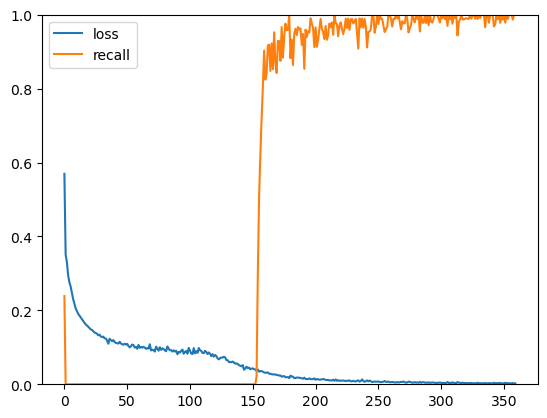

In [14]:
# Plot training metrics

plt.figure()
plt.plot(history['loss'], label="loss")
plt.plot(history['recall'], label="recall")
plt.legend()
plt.ylim(0,1)


## Try the Model on an Example Clip

To confirm that the model is working as expected, let's test it on an example audio file (obtained from Youtube) of someone talking and then saying the phrase "turn on the office lights" at the end of the clip. We'll simulate how the model would be used in production, by predicting every 80 ms (1280 samples) and plotting the predictions over time.

This clip is a good sanity test to confirm the model is performing in the right way, as it contains about ~30 seconds of speech that does no contain the target phrase, but does contain related words (e.g., "lights") that should not result in an activation. So ideally, the model scores are low up to the end of the recording, where there should then be a spike right after the target spoken phrase.

100%|██████████| 394/394 [00:00<00:00, 19403.48it/s]


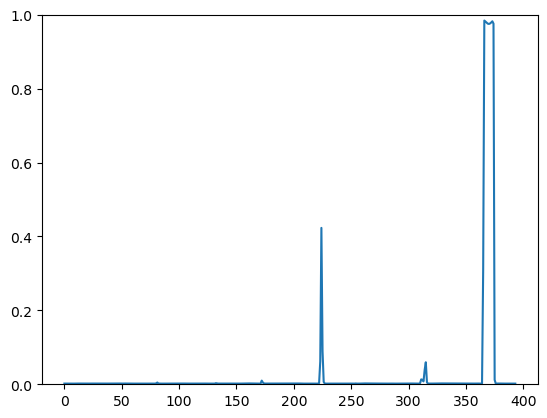

In [16]:
# Load data
sr, dat = scipy.io.wavfile.read("training_tutorial_data/turn_on_the_office_lights_test_clip.wav")

# Pre-compute audio features using helper function
features = F._get_embeddings(dat)

# Get predictions for each window
scores = []
for i in tqdm(range(0, features.shape[0]-28)): # 28 is the number of timestep frames for this model
    window = features[i:i+28][None,]
    with torch.no_grad():
        scores.append(float(fcn(torch.from_numpy(window)).detach().numpy()))
    
plt.figure()
_ = plt.plot(scores)
_ = plt.ylim(0,1)


Overall, the model is working well on this test clip. There are a few spikes around the word "lights" spoken in other contexts, but the clear activation is around the entire phrase.

To make this test a little more difficult, let's arbitrarily mix the test clip with some background music from the fma-large dataset at a low signal-to-noise ratio to simulate a more realistic (and challenging) scenario. Listen to the clip below to get a more intuitive feel of what the type of audio environment this represents.

In [19]:
# Load two clips and mix them
_, dat = scipy.io.wavfile.read("turn_on_the_office_lights_test_clip.wav")
_, dat_music = scipy.io.wavfile.read("fma_sample/000182.wav")
dat[-20*16000:] = (dat[-20*16000:] + dat_music[0:20*16000]*.7)/2 #quick manual mixing

ipd.display(ipd.Audio(dat[-16000*6:], rate=16000, normalize=True, autoplay=False))

100%|██████████| 394/394 [00:00<00:00, 19051.83it/s]


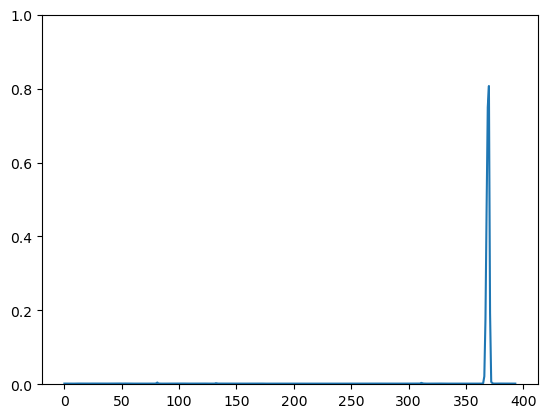

In [20]:
# Pre-compute audio features using helper function
features = F._get_embeddings(dat)

# Get predictions for each window
scores = []
for i in tqdm(range(0, features.shape[0]-28)): # 28 is the number of timestep frames for this model
    window = features[i:i+28][None,]
    with torch.no_grad():
        scores.append(float(fcn(torch.from_numpy(window)).detach().numpy()))
    
plt.figure()
_ = plt.plot(scores)
_ = plt.ylim(0,1)

The model is now less confidant in it's prediction than before, but the score is still above a default score of 0.5 which confirms that the model at least represents a good starting point.

# Export the Model

Now that the model is trained and passes basic performance validation tests, it can be exported to ONNX so that it can be used by the openWakeWord inference engine. With Torch, this process is quite simple.

In [21]:
# Export model to ONNX format

output_path = "turn_on_the_office_lights.onnx"
torch.onnx.export(fcn, args=torch.zeros((1, 28, 96)), f=output_path) # the 'args' is the shape of a single example

# Evaluate the Model

Let's now load in the ONNX model with openWakeWord, and use that to run some more rigorous testing. First, let's just confirm that the ONNX model works as expected.

In [22]:
# Create openWakeWord instance

oww = openwakeword.Model(
    wakeword_model_paths=["turn_on_the_office_lights.onnx"],
    enable_speex_noise_suppression=True,
    vad_threshold=0.5
)


/home/dscripka/anaconda3/envs/torch_gpu/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:54: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


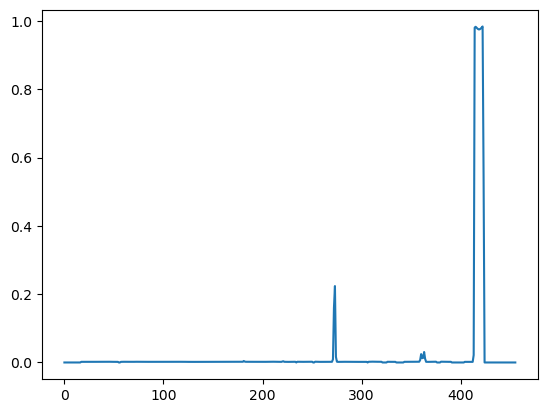

In [23]:
# Do a quick test prediction on the test clip to confirm that the behavior is still as expected

scores = oww.predict_clip("turn_on_the_office_lights_test_clip.wav")

plt.figure()
_ = plt.plot([i["turn_on_the_office_lights"] for i in scores])

Since that looks fine, we can now conduct a more rigorous test to evaluate the false-accept rate in something closer to a production scenario. Specifically, we want the openWakeWord models to respond consistently when a user speaks the target wake word/phrase, but also does not activate even in the presence of many hours of continuous background noise and un-related speech.

To test that, we'll use a few clips (for a total of ~ 1 hour) from the [Santa Barbara Corpus of Spoken American English](https://www.linguistics.ucsb.edu/research/santa-barbara-corpus) to produce a more realistic metric for the false-activation rate per hour.

The combined clip (already converted to a single-channel, 16khz, 16-bit WAV file) can be downloaded [here](https://f002.backblazeb2.com/file/openwakeword-resources/data/santa_barbara_corpus_test_clip.wav).


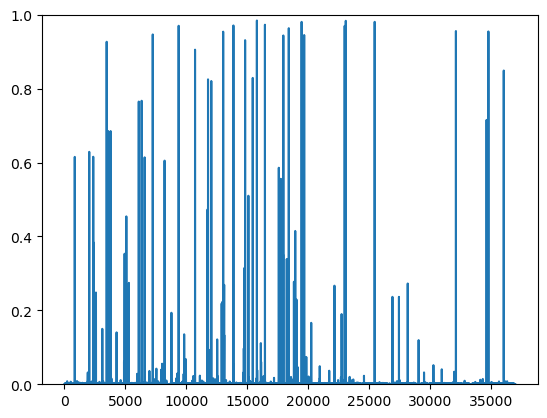

In [24]:
# Estimate the false-accept rate on realistic test data (will take up to several minutes an a desktop-grade CPU)

scores = oww.predict_clip("santa_barbara_corpus_test_clip.wav")

plt.figure()
_ = plt.plot([i["turn_on_the_office_lights"] for i in scores])
_ = plt.ylim(0,1)

In [25]:
# Calculate the false-accept rate per hour from this result

false_accepts = openwakeword.metrics.get_false_positives(
    [i["turn_on_the_office_lights"] for i in scores], threshold=0.5
)

print(f"False-accept rate per hour: {false_accepts/1}")

False-accept rate per hour: 94.0


It looks like the false-accept rate for this model is very high, and would need to be reduced quite significantly to be viable for a production deployment. Of course, this was expected as the model was trained on a very small amount of positive and negative data.

# Create a User-specific Verifier Model

As we saw, the simple model trained on this dataset performs quite well at detecting the presence of the wakeword/phrase, but often activates when it shouldn't, leading to an unnacceptably high false-accept rate.

In practice, there are two ways to improve the performance of the model:

1) Train on much larger amounts of positive and negative examples. The models released with openWakeWord are often trained on >100,000 positive examples, and over 30,000 hours of negative data.

2) Create a user-specific "verifier" model based on examples of a specific person speaking the both the wake word/phrase and unrelated speech. The openWakeWord inference engine uses this verifier model to filter out likely false activations by focusing on only known speakers.

We'll demonstrate the 2nd option here, as it's a very quick way to significantly improve performance at the cost of making the model far less likely to work well with other voices. The approach behind this verifier model are relatively simple, and are discussed in more detail in the openWakeWord documentation [here](https://github.com/dscripka/openWakeWord/docs/custom_verifier_models.md).

For test data, we'll use 20 examples of the wake phrase generated with the [Tortoise](https://github.com/neonbjb/tortoise-tts) TTS model. While this is also synthetic data, it's very high quality and trained on different data than the TTS models used to generate training data. For unrelated speech, an English [phonetic pangram](https://www.liquisearch.com/list_of_pangrams/english_phonetic_pangrams) sentence was generated with the same TTS voice.

This example wake phrase clips and reference negative speech (phonetic pangram) are included in the openWakeWord repo (in the `notebooks/training_tutorial_data` directory).

In [26]:
# Provide paths to positive and negative speech from the target speaker for training a custom
# verifier model

reference_clips = [str(i) for i in Path("training_tutorial_data/positive/").glob("*.wav")]
negative_clips = [str(i) for i in Path("training_tutorial_data/negative/").glob("*.wav")]

# Listen to one of the clips
ipd.display(ipd.Audio(reference_clips[0], rate=16000, normalize=True, autoplay=False))

Now that we have the data (note that all of the clips *must* be 16 khz, 16-bit PCM WAV files), we can train a custom verifier model. This is simply a scikit-learn logistic regression model, using the same audio features from the normal openWakeWord pre-processor, so it is very fast to train and adds negligble time to the openWakeWord inference engine.

In [27]:
# Train verifier model on the reference clips

output_model_path = "turn_on_the_office_lights_verifier.pkl"
openwakeword.train_custom_verifier(
    positive_reference_clips = reference_clips[0:3], # use 3 reference examples for the wake phrase
    negative_reference_clips = negative_clips,
    output_path = output_model_path,
    model_name = "turn_on_the_office_lights.onnx"
)


Processing negative reference clips: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


Training and saving verifier model...
Done!


After the model is trained, we can instantiate a new openWakeWord instance and include the path to the trained verifier model, as well as set the threshold score from the base model required to invoke the verifier. In practice, you can set this threshold score a bit lower than normal, though as usual actual testing in the deployment environment is recommended.

In [28]:
# Create openWakeWord instance with verifier model

oww = openwakeword.Model(
    wakeword_model_paths=["turn_on_the_office_lights.onnx"],
    enable_speex_noise_suppression=True,
    vad_threshold=0.5,
    custom_verifier_models={"turn_on_the_office_lights": "turn_on_the_office_lights_verifier.pkl"},
    custom_verifier_threshold=0.3,
)


/home/dscripka/anaconda3/envs/torch_gpu/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:54: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


Finally, we can run the model on our test clip from the Santa Barbara corpus and see if the false activation rate has decreased to an acceptable level.

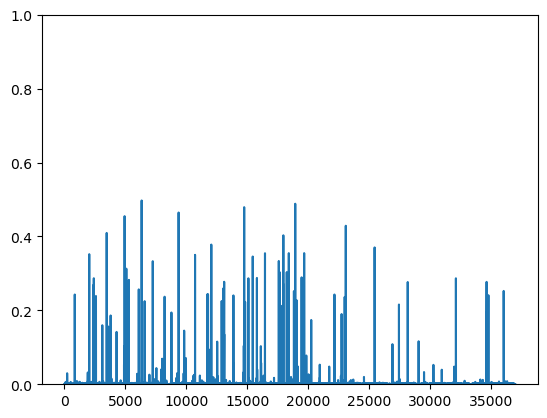

In [29]:
# Run false-accept rate test again, now with the verifier model

scores = oww.predict_clip("santa_barbara_corpus_test_clip.wav")

plt.figure()
plt.plot([i["turn_on_the_office_lights"] for i in scores])
_ = plt.ylim(0,1)


In [30]:
# Calculate the false-accept rate per hour from this new result

false_accepts = openwakeword.metrics.get_false_positives(
    [i["turn_on_the_office_lights"] for i in scores], threshold=0.5
)

print(f"False-accept rate per hour: {false_accepts/1}")

False-accept rate per hour: 0.0


Sucess! Now the false-activation rate is at most <1 per hour given that there weren't any false-positives in our ~1 hour test clip, which is an orders of magnitude decrease! This model is now much closer to being ready for a production deployment, assuming that each user is known and can provide the neccessary data to train the verifier model.